In [1]:
import sys
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

atlas_path = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/x64/Debug"
sys.path.append(atlas_path)


from AtlasPy.core import Hydra, Portfolio, Strategy
from AtlasPy.ast import *

In [2]:
exchange_path = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/AtlasPy/src/exchangeVBT"
strategy_id = "test_strategy"
exchange_id = "test_exchange"
portfolio_id = "test_portfolio"

hydra = Hydra()
intial_cash = 100.0
exchange = hydra.addExchange(exchange_id, exchange_path, "%Y-%m-%d %H:%M:%S")
portfolio = hydra.addPortfolio(portfolio_id, exchange, intial_cash)
hydra.build()

In [3]:
st = time.time()
atr_node = ATRNode.make(
    exchange,
    "High",
    "Low",
    14
) 
et = time.time()
print(f'Elapsed time {1000*(et-st):.2f} ms')

Elapsed time 14.27 ms


In [6]:
multiplier = 2
median_node = AssetMedianNode.make(
    exchange,
    "High",
    "Low"
)
close = AssetReadNode.make("Close", 0, exchange)
upper_band = AssetOpNode.make(
    median_node,
    AssetScalerNode(atr_node, AssetOpType.MULTIPLY, multiplier),
    AssetOpType.ADD
)
lower_band = AssetOpNode.make(
    median_node,
    AssetScalerNode(atr_node, AssetOpType.MULTIPLY, multiplier),
    AssetOpType.SUBTRACT
)
spread_upper = AssetOpNode.make(close, upper_band, AssetOpType.SUBTRACT)
spread_lower = AssetOpNode.make(close, lower_band, AssetOpType.SUBTRACT)
spread_filter_up = ExchangeViewFilter(ExchangeViewFilterType.GREATER_THAN, 0.0, None)
spread_filter_down = ExchangeViewFilter(ExchangeViewFilterType.LESS_THAN, 0.0, None)
exchange_view_up = ExchangeViewNode.make(exchange, spread_upper, spread_filter_up)
exchange_view_down = ExchangeViewNode.make(exchange, spread_lower, spread_filter_down, exchange_view_up)
allocation_signal = AllocationNode.make(
    exchange_view_down,
    AllocationType.CONDITIONAL_SPLIT,
    0.0
)
strategy_node_signal = StrategyNode.make(allocation_signal, portfolio)
strategy = hydra.addStrategy(Strategy(strategy_id, strategy_node_signal, 1.0), True)
strategy.enableTracerHistory(TracerType.NLV)

In [7]:
hydra.run()

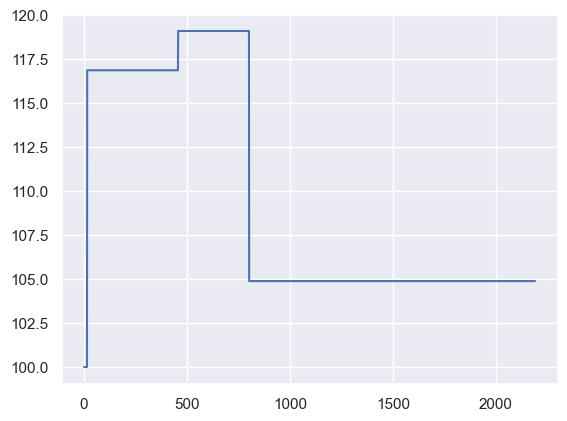

In [9]:
plt.plot(strategy.getHistory(TracerType.NLV))